# Toxic App - DSC478 Final Project

#### Authors: *Jeffrey Bocek, Xuyang Ji & Anna-Lisa Vu*

Python application that identifies whether a comment is toxic. This app can be used as a third-party library for social media sites or public sites where users are allowed to leave comments.  When the application starts up, it will train multiple models against an existing data set.  Once the models are trained, the user will be prompted to enter a comment.

## **Notebook 1 - Preprocessing**

#### Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
import operator #for sorting 
from sklearn import preprocessing # for normalization 
from collections import Counter #finding the majority 

#Text Preprocessing 
import re # for number removal 
import string # for punctutation removal 

import nltk 
## for stopword removal
from nltk.corpus import stopwords
nltk.download('stopwords')
stopWords= stopwords.words('english')
## lemmatization 
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
lemmatizer= WordNetLemmatizer()
from nltk.tokenize import word_tokenize

import pickle  #save variables to file

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lisasaurus01/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lisasaurus01/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lisasaurus01/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def load_file(filename):
    'load the dataset into the notebook'

    file = pd.read_csv(filename)
    return file


In [3]:
def load_mult_files(list_files):
    'load multiple files'

    file_list = {}
    for ds in list_files:
        file_list[ds] = load_file(ds)
    return file_list


In [4]:
def reconfigure_categories(train_df, test_lab):
    'add categories to df'

    def plot_df_distributions(df, position, chart_title):
        'make a bar chart of df distributions'
        target_column =list(df.columns[position:])
        labelC = df[target_column].sum()
        plt.figure(figsize=(10,7))
        ax = sns.barplot(x=labelC.index, y=labelC.values,dodge=False)
        ax.set_yscale('log')
        ax.tick_params(labelsize=7)
        plt.title(chart_title)
        for i in ax.containers:
            ax.bar_label(i,)
    
    def config_train(train_df, position):
        target_col = list(train_df.columns[position:])
        #fill toxic column of sever toxic comments with 1 
        train_df.loc[train_df['severe_toxic']==1,'toxic'] =1

        # non-toxic comments are identified when all target_col value is 0. New column has been created,
        # if value of 1 then the comment is nontoxic
        train_df['non_toxic'] = 1-train_df[target_col].max(axis=1)

        # Since labels nested under each other in some cases, comments with toxicity defined are identified
        # with new column
        train_df['toxicity_defined'] = train_df[['insult', 'obscene', 'identity_hate', 'threat']].max(axis=1)

        # New toxic_undefined column for toxic comments but with no characteristic
        train_df['toxicity_undefined'] = 0  # initiziling all value of 0
        # for each comment that's not toxicity defined but labelled as toxic, labeled them as 1 in new column
        train_df.loc[(train_df['toxicity_defined'] == 0) & (train_df['toxic'] == 1), 'toxicity_undefined'] = 1

        # New mild_toxicity column for comment with toxicity defined but not labeled as toxic/severe toxic
        train_df['mild_toxicity'] = 0
        train_df.loc[(train_df['toxicity_defined'] == 1) & (train_df['toxic'] == 0) & (train_df['severe_toxic'] == 0),
                'mild_toxicity'] = 1

        #Now, we would create one variable including 4 levels:
        # level 0: Non-toxic comment (6% of the original dataset)
        # level 1: Mild_toxicity
        # level 2: Toxic (since all severe toxic comment are labeled as 1 in toxic comment, they are removed)
        # level 3: severe_toxic

        train_df['toxicity_level']=0 #initializing a column of 0
        train_df.loc[(train_df['non_toxic']==1),'toxicity_level']=1
        train_df.loc[(train_df['mild_toxicity']==1),'toxicity_level']=2
        train_df.loc[(train_df['toxic']==1)& (train_df['severe_toxic']==0),'toxicity_level']=3
        train_df.loc[(train_df['severe_toxic']==1), 'toxicity_level']=4

        #drop rows with toxicity level undefined
        train_df= train_df[train_df['toxicity_level']!= 0]

        #make sure the toxic comments does not include severe toxic comments
        train_df.loc[train_df['severe_toxic'] == 1, 'toxic'] = 0

        return train_df

    def config_test_lab(test_lab, position):
        test_lab = test_lab[~test_lab.isnull().any(axis=1)]
        target_col = list(test_lab.columns[position:])
        #fill toxic column of sever toxic comments with 1 
        test_lab.loc[test_lab['severe_toxic']==1,'toxic'] =1

        # non-toxic comments are identified when all target_col value is 0. New column has been created,
        # if value of 1 then the comment is nontoxic
        test_lab['non_toxic'] = 1-test_lab[target_col].max(axis=1)

        # Since labels nested under each other in some cases, comments with toxicity defined are identified
        # with new column
        test_lab['toxicity_defined'] = test_lab[['insult', 'obscene', 'identity_hate', 'threat']].max(axis=1)

        # New toxic_undefined column for toxic comments but with no characteristic
        test_lab['toxicity_undefined'] = 0  # initiziling all value of 0
        # for each comment that's not toxicity defined but labelled as toxic, labeled them as 1 in new column
        test_lab.loc[(test_lab['toxicity_defined'] == 0) & (test_lab['toxic'] == 1), 'toxicity_undefined'] = 1

        # New mild_toxicity column for comment with toxicity defined but not labeled as toxic/severe toxic
        test_lab['mild_toxicity'] = 0
        test_lab.loc[(test_lab['toxicity_defined'] == 1) & (test_lab['toxic'] == 0) & (test_lab['severe_toxic'] == 0),
                'mild_toxicity'] = 1

        #Now, we would create one variable including 4 levels:
        # level 0: Non-toxic comment
        # level 1: Mild_toxicity
        # level 2: Toxic (since all severe toxic comment are labeled as 1 in toxic comment, they are removed)
        # level 3: severe_toxic

        test_lab['toxicity_level']=0 #initializing a column of 0
        test_lab.loc[(test_lab['non_toxic']==1),'toxicity_level']=1
        test_lab.loc[(test_lab['mild_toxicity']==1),'toxicity_level']=2
        test_lab.loc[(test_lab['toxic']==1)& (test_lab['severe_toxic']==0),'toxicity_level']=3
        test_lab.loc[(test_lab['severe_toxic']==1), 'toxicity_level']=4

        #drop rows with toxicity level undefined
        test_lab= test_lab[test_lab['toxicity_level']!= 0]

        #make sure the toxic comments does not include severe toxic comments
        test_lab.loc[test_lab['severe_toxic'] == 1, 'toxic'] = 0

        return test_lab
    '''
    def config_train(train_df, position):
            target_col = list(train_df.columns[position:])
            train_df['non_toxic'] = 1 - train_df[target_col].max(axis=1)
            train_df['overall_toxic'] = train_df[target_col].max(axis=1)
            return train_df
    
    def config_test_lab(test_lab, position):
            target_col = list(test_lab.columns[position:])
            test_lab['non_toxic'] = 1 - test_lab[target_col].max(axis=1)
            test_lab['overall_toxic'] = abs(test_lab[target_col].max(axis=1))
            return test_lab
        '''
    
    train_df = config_train(train_df, 2)
    test_lab = config_test_lab(test_lab, 2)

    plot_df_distributions(train_df, 2, "Training Data Class Distribution")
    plot_df_distributions(test_lab, 2, "Test Data Class Distribution")
    
    return train_df, test_lab

In [5]:
def filter_df(train_df, test_lab):
    'create updated dataframe'
    train_df = train_df[['comment_text','non_toxic', 'overall_toxic']]
    test_lab = test_lab[['non_toxic', 'overall_toxic']]
    return train_df, test_lab

In [6]:
def train_subsample_df(train_df, nontox_frac, tox_frac):
    'take a subsample of the dataframe based on a fractions of the distributions'

    nonToxic= train_df[['comment_text']].sample(frac = nontox_frac, random_state = 961)
    toxic = train_df[['comment_text']].sample(frac = tox_frac, random_state = 961)
    train_df = nonToxic.append(toxic)

    return train_df

In [7]:
def test_lab_subsample_df(test_lab, nontox_frac, tox_frac):
    'take a subsample of the dataframe based on a fractions of the distributions'

    nonToxic= test_lab['non_toxic'].sample(frac = nontox_frac, random_state = 961)
    toxic = test_lab['overall_toxic'].sample(frac = tox_frac, random_state = 961)
    test_lab = nonToxic.append(toxic)
    return test_lab


In [8]:
# 1 - 0.01
# 2 -
# 3 - 0.10
# 4
def get_subsample(data, nontox_frac, mildtox_frac, toxic_frac, severetoxic_frac, chart_title):
    data=data[['comment_text', 'non_toxic','mild_toxicity','toxic','severe_toxic','toxicity_level']]

    non_toxic= data[data['toxicity_level']==1].sample(frac=nontox_frac,random_state=961)
    #print("Non toxic shape:"+str(nonToxic.shape))

    mild_toxic= data[data['toxicity_level']==2].sample(frac=mildtox_frac,random_state=961)
    #print("Mildtoxic shape:"+str(nonToxic.shape))

    toxic = data[data['toxicity_level']==3].sample(frac=toxic_frac,random_state=961)
    #print("Toxic shape:"+str(toxic.shape))

    severe_toxic = data[data['toxicity_level']==4].sample(frac=severetoxic_frac,random_state=961)
    #print("Toxic shape:"+str(toxic.shape))

    data = non_toxic.append(mild_toxic).append(toxic).append(severe_toxic)
    print(data[['toxicity_level']].value_counts())

    #make sure the toxic comments does not include severe toxic comments
    data.loc[data['severe_toxic'] == 1, 'toxic'] = 0

    target= list(data.columns.drop(['comment_text','toxicity_level']))
    label= data[target].sum()
    plt.figure(figsize=(5,5))
    ax = sns.barplot(x=label.index, y=label.values)
    ax.tick_params(labelsize=7)
    plt.title(chart_title)
    for i in ax.containers:
        ax.bar_label(i,)

    return data

In [9]:
#Text Preprocessing 

#Removing punctuations'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
def remove_punc(comment):
    nonPunc="".join([letter for letter in comment if letter not in string.punctuation])
    return nonPunc

#Lowering the text
def toLower(comment):
    return comment.lower()

#Removing numbers 
def replace_numbers(comment):
    """Replace all interger occurrences in 
    list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', comment)

#Removing whitespaces
def remove_space(comment):
    return comment.strip()

#Tokenization
def text2word(comment):
    return word_tokenize(comment)

#Removing Stop words
def remove_stopW(words,stopWords):
    return [word for word in words if word not in stopWords]

#Lemmatization
def lematizer(words):
    lemmatizer = WordNetLemmatizer()
    lemm_comm= [lemmatizer.lemmatize(word) for word in words]
    return lemm_comm

def lematizer_verb(words):
    lemmatizer = WordNetLemmatizer()
    lemm_comm= [lemmatizer.lemmatize(word,"v") for word in words]
    return lemm_comm


def clean_comment(comment):
    comment= remove_punc(comment)
    comment= toLower(comment)
    comment= replace_numbers(comment)
    comment= remove_space(comment)
    words=text2word(comment)
    words=remove_stopW(words,stopWords)
    words=lematizer(words)
    words=lematizer_verb(words)
    
    return ' '.join(words)

In [10]:
def clean_comments(train_df, test_df):
    'clean comments in dataframes'

    train_df['comment_text'] = train_df['comment_text'].apply(lambda x: clean_comment(x))
    test_df['comment_text'] = test_df['comment_text'].apply(lambda x: clean_comment(x))
    return train_df, test_df

In [11]:
def reset_index(df):
    'reset index of df'

    df= df.reset_index(drop=True)
    return df

In [12]:
def store_dfs(file_name, dfs):
    'store dataframes to file'

    clean_data = dfs
    with open(file_name, 'wb') as my_file_object:
        pickle.dump(clean_data, my_file_object)

In [13]:
datasets = load_mult_files(['train.csv', 'test.csv'])
train_df, test_comments, = datasets.values()
test_labels = pd.read_csv('test_labels.csv', header=0, na_values=-1)

#merge the test_df and test_lab data frames
test_df = pd.merge(test_comments, test_labels, on="id")

test_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,NaN,NaN,NaN,NaN,NaN,NaN
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,NaN,NaN,NaN,NaN,NaN,NaN
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",NaN,NaN,NaN,NaN,NaN,NaN
3,00017563c3f7919a,":If you have a look back at the source, the in...",NaN,NaN,NaN,NaN,NaN,NaN
4,00017695ad8997eb,I don't anonymously edit articles at all.,NaN,NaN,NaN,NaN,NaN,NaN


/var/folders/c4/lz0fty3s6b3148w_cbvkndwm0000gn/T/ipykernel_1052/1476967791.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_lab['non_toxic'] = 1-test_lab[target_col].max(axis=1)
/var/folders/c4/lz0fty3s6b3148w_cbvkndwm0000gn/T/ipykernel_1052/1476967791.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_lab['toxicity_defined'] = test_lab[['insult', 'obscene', 'identity_hate', 'threat']].max(axis=1)
/var/folders/c4/lz0fty3s6b3148w_cbvkndwm0000gn/T/ipykernel_1052/1476967791.py:74: SettingWithCo

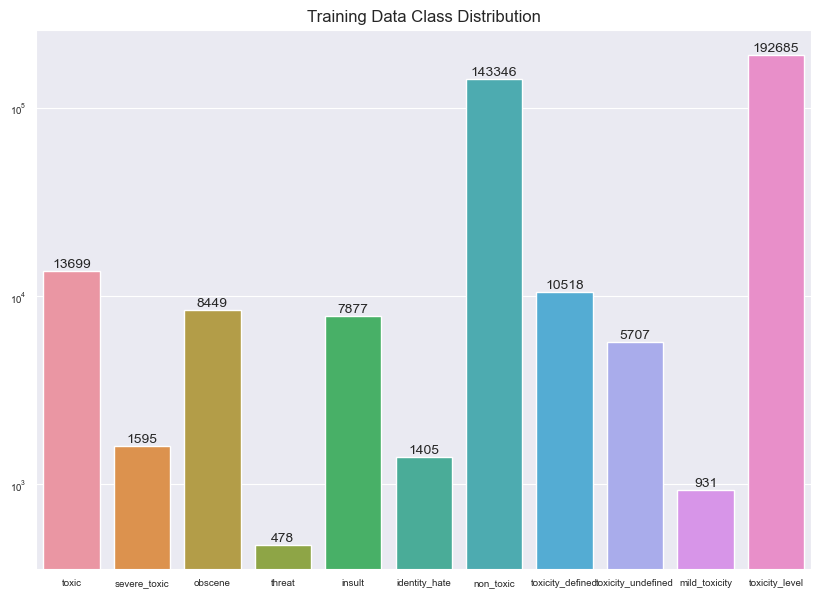

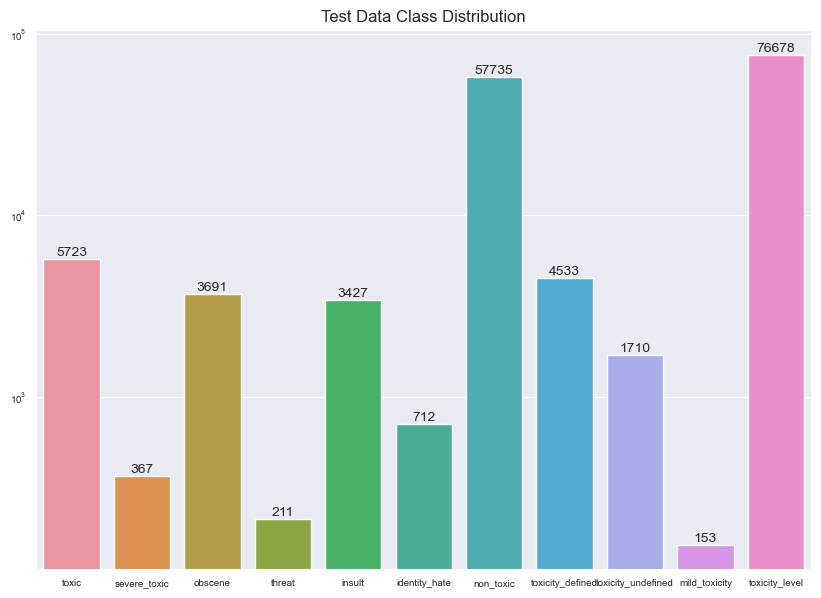

In [14]:
train_df, test_lab = reconfigure_categories(train_df, test_df)

### Final Set of Steps to Clean Data and Reduce Data Sets

/var/folders/c4/lz0fty3s6b3148w_cbvkndwm0000gn/T/ipykernel_1052/1476967791.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_lab['non_toxic'] = 1-test_lab[target_col].max(axis=1)
/var/folders/c4/lz0fty3s6b3148w_cbvkndwm0000gn/T/ipykernel_1052/1476967791.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_lab['toxicity_defined'] = test_lab[['insult', 'obscene', 'identity_hate', 'threat']].max(axis=1)
/var/folders/c4/lz0fty3s6b3148w_cbvkndwm0000gn/T/ipykernel_1052/1476967791.py:74: SettingWithCo

toxicity_level
4                 1595
1                 1433
3                 1370
2                  931
dtype: int64
toxicity_level
1                 577
3                 572
4                 367
2                 153
dtype: int64
Train df shape = (5329, 6)
Test df shape = (1669, 6)


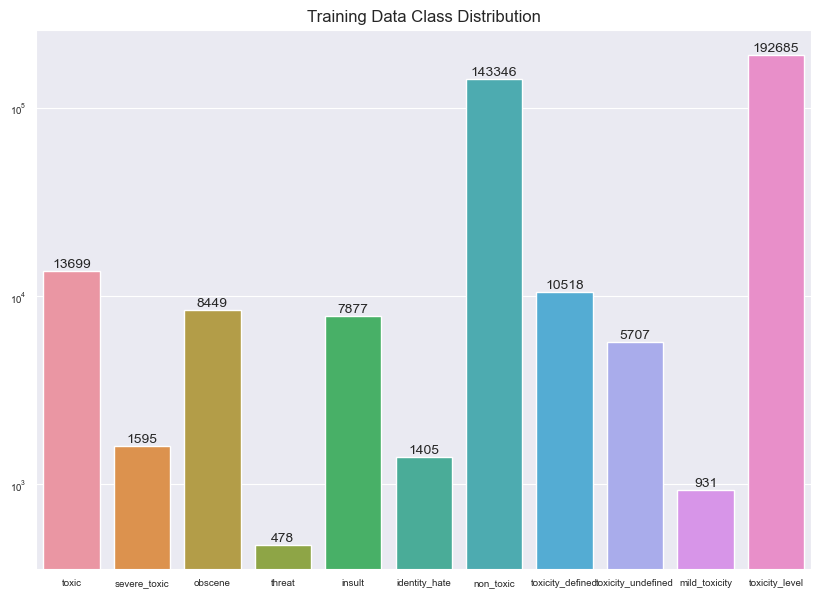

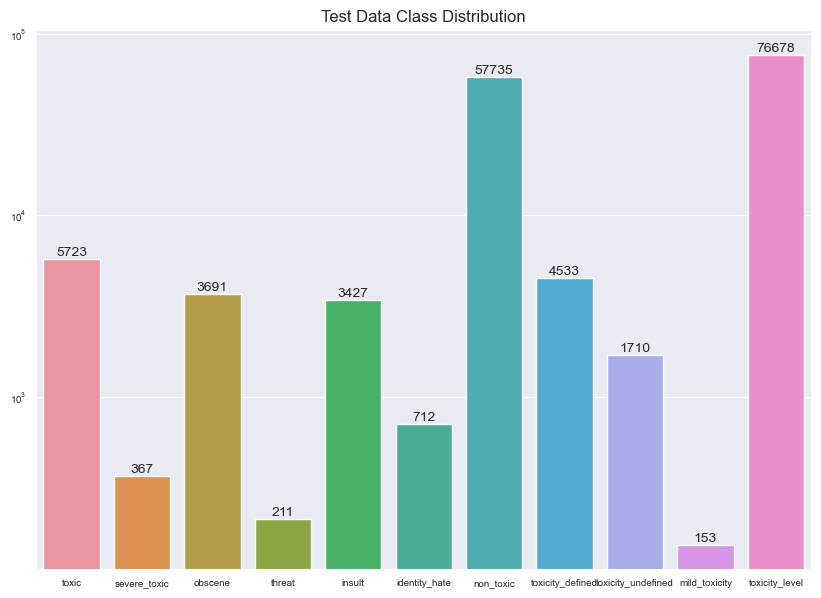

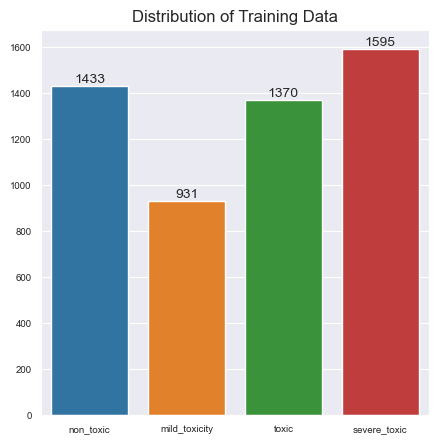

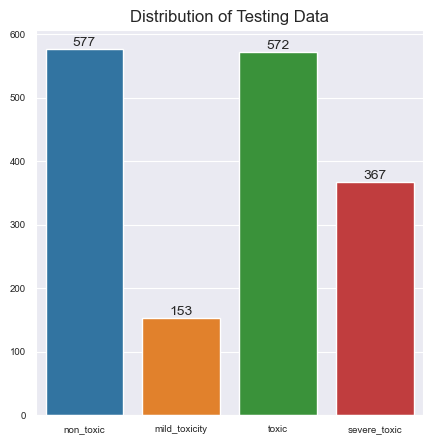

In [15]:
datasets = load_mult_files(['train.csv', 'test.csv'])
train_df, test_comments, = datasets.values()
test_labels = pd.read_csv('test_labels.csv', header=0, na_values=-1)

#merge the test_df and test_lab data frames
test_df = pd.merge(test_comments, test_labels, on="id")

train_df, test_df = reconfigure_categories(train_df, test_df)

#train_df, test_lab = filter_df(train_df, test_lab)

#can change what percent of the distributions we want to have
#train_subsample_df(train_df, 1, 1)
#test_lab_subsample_df(test_lab, 1, 1)

# the fractions below correspond to each toxicity level.  They can be adjusted accordingly.
train_df = get_subsample(train_df, 0.01, 1.0, .10, 1.0, "Distribution of Training Data")
test_df = get_subsample(test_df, 0.01, 1.0, .10, 1.0, "Distribution of Testing Data")

print('Train df shape = ' +str(train_df.shape))
print('Test df shape = ' +str(test_df.shape))

train_df, test_df = clean_comments(train_df, test_df)
#test
#train_df["comment_text"].iloc[2]

for df in [train_df, test_df]:
   reset_index(df)

#can input file name to correspond with percent of distributions
store_dfs('clean_data1.p', [train_df, test_df])


In [16]:
train_df["comment_text"].iloc[2]

'article cant remember password jim bakken im fieldgoalunit include tyldesley complete worcs time ill summarise test cricket time study protocol detail im afraid fact apart typo link need fix would grateful someone would many cricket article inaccuracy ramble tale attach bob taylor one worst wrong match highest score wrong series night watchman story therefore nonsense also never challenge knott place'

In [17]:
test_df["comment_text"].iloc[2]

'relevant manual style require title list define include role give lede indeed require overprecise title article note word country good precise write distinctly ambiguous open ream interpretation give mo say list inclusion criterion unambiguous objective support reliable source inclusion criterion propose use article'

In [18]:
test_lab.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic,toxicity_defined,toxicity_undefined,mild_toxicity,toxicity_level
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1
7,000247e83dcc1211,:Dear god this site is horrible.,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1
